In [1]:
#load packages 
import numpy as np
import pandas as pd
import scipy
from PIL import Image
import glob
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from pandarallel import pandarallel
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [13]:
#grab file path names
image_paths = glob.glob("../data/movie-genre-from-its-poster/SampleMoviePosters/SampleMoviePosters/*.jpg")
image_ids = []
for path in image_paths:
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids.append(path[start:end])

In [14]:
df_movie = pd.read_csv("../data/movie-genre-from-its-poster/MovieGenre.csv", encoding = "ISO-8859-1")

In [15]:
df_movie.shape

(40108, 6)

In [16]:
df_movie.head(1)

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...


In [17]:
df_movie_sample = df_movie[df_movie["imdbId"].isin(image_ids)]
df_movie_sample = df_movie_sample.drop_duplicates(subset=['imdbId'], keep="last")

In [18]:
df_movie_sample.shape

(997, 6)

In [19]:
df_movie_sample['Genre']

877               Drama|Romance
888              Comedy|Romance
890      Comedy|Musical|Romance
940                       Drama
942               Drama|Romance
                  ...          
39884    Animation|Short|Comedy
39890    Animation|Short|Comedy
40044              Comedy|Short
40057                     Drama
40064             Drama|Romance
Name: Genre, Length: 997, dtype: object

### Apply tuple in parallel

In [20]:
def convert_tuple(list): 
    return tuple(i for i in list) 

In [21]:
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [22]:
df_movie_sample["Genre"] = df_movie_sample["Genre"].str.split("|")

In [23]:
df_movie_sample["Genre"] = df_movie_sample["Genre"].parallel_apply(convert_tuple)

In [24]:
target = df_movie_sample['Genre']

In [25]:
X = df_movie_sample.drop("Genre", axis =1)
y = df_movie_sample["Genre"]

In [26]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
target_key = mlb.classes_

In [27]:
images = []
for img in image_paths:
    try:
        img = load_img(img, target_size=(256,256))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
    except:
        pass

images = np.vstack(images)

In [28]:
# images = np.array([img_to_array(
#                     load_img(img, target_size=(256,256))
#                     ) for img in image_paths])

In [29]:
images = images.astype('float32')/255.0

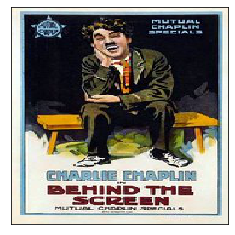

In [30]:
#sample image
plt.imshow(images[2]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);

In [40]:
target_labels = target_key
total_classes = len(set(target_labels))
print("number of genre:", total_classes)

number of genre: 23


In [41]:
len(image_ids)

997

In [42]:
images.shape

(997, 256, 256, 3)

In [43]:
y.shape

(997, 23)

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(images, y, 
                                                     random_state=42)

In [45]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [46]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(total_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

In [47]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Train on 747 samples, validate on 250 samples
Epoch 1/10
747/747 [==============================] - 27s 36ms/sample - loss: 0.4991 - accuracy: 0.7703 - val_loss: 0.3271 - val_accuracy: 0.9127
Epoch 2/10
747/747 [==============================] - 28s 38ms/sample - loss: 0.3864 - accuracy: 0.8431 - val_loss: 0.2790 - val_accuracy: 0.9127
Epoch 3/10
747/747 [==============================] - 28s 38ms/sample - loss: 0.3384 - accuracy: 0.8743 - val_loss: 0.2515 - val_accuracy: 0.9127
Epoch 4/10
747/747 [==============================] - 27s 36ms/sample - loss: 0.3072 - accuracy: 0.8895 - val_loss: 0.2477 - val_accuracy: 0.9127
Epoch 5/10
747/747 [==============================] - 28s 37ms/sample - loss: 0.2869 - accuracy: 0.8976 - val_loss: 0.2483 - val_accuracy: 0.9127
Epoch 6/10
747/747 [==============================] - 28s 38ms/sample - loss: 0.2673 - accuracy: 0.9046 - val_loss: 0.2458 - val_accuracy: 0.9129
Epoch 7/10
747/747 [==============================] - 26s 35ms/sample - loss: 

In [41]:
img_test_predict = np.reshape(images[4], (1, 256, 256, 3))

ValueError: cannot reshape array of size 196608 into shape (1,182,268,3)

In [37]:
def poster_classification(img, target_key=target_key, model=model, ):
    proba = model.predict(img)[0]
    idxs = np.argsort(proba)[::-1][:2]
    print("Poster Prediction")
    for (i, j) in enumerate(idxs):
        label = "{}: {:.2f}%".format(target_key[j], proba[j] * 100)
    for (label, p) in zip(target_key, proba):
        if p >= .4:
            print("{}: {:.2f}%".format(label, p * 100))
            
    plt.imshow(img[0]);
    plt.grid(True);
    plt.xticks([]);
    plt.yticks([]);

In [38]:
def poster_classification_database(idx=7, images=images, target=target, target_key=target_key, model=model):
    img = np.reshape(images[idx], (1, 256, 256, 3))
    proba = model.predict(img)[0]
    idxs = np.argsort(proba)[::-1][:2]
    print("Poster Prediction")
    for (i, j) in enumerate(idxs):
        label = "{}: {:.2f}%".format(target_key[j], proba[j] * 100)
    for (label, p) in zip(target_key, proba):
        if p >= .45:
            print("{}: {:.2f}%".format(label, p * 100))
            
    plt.imshow(img[0]);
    plt.grid(True);
    plt.xticks([]);
    plt.yticks([]);
    print("")
    print(f"True poster genre:{target.iloc[idx]}")

In [39]:
poster_classification(img_test_predict)

NameError: name 'img_test_predict' is not defined

In [40]:
poster_classification_database(20)

ValueError: Error when checking input: expected conv2d_3_input to have shape (182, 268, 3) but got array with shape (256, 256, 3)

Poster Prediction
Drama: 80.19%

True poster genre:('Adventure', 'Romance', 'Western')


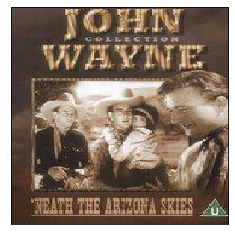

In [154]:
poster_classification_database(278)

In [34]:
model = load_model("../model/large_movie_poster_2020-05-25/")

In [42]:
img_test_predict = np.array([img_to_array(
                    load_img(image_paths[0], target_size=(182,268))
                    )])
img_test_predict = img_test_predict.astype('float32')/255.0

Poster Prediction
Family: 50.64%


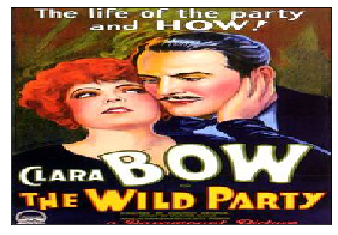

In [43]:
poster_classification(img_test_predict)